In [41]:
#https://docs.openvino.ai/latest/notebooks/002-openvino-api-with-output.html
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os, sys

In [42]:
from openvino.runtime import Core

ie = Core()
model_xml = "./logs/lego_test/model_300000/xml/saved_model.xml"
model = ie.read_model(model=model_xml)
compile_model = ie.compile_model(model=model, device_name="CPU")

In [43]:
compile_model.outputs[0]

<ConstOutput: names[Func/StatefulPartitionedCall/output/_25:0, Identity:0, StatefulPartitionedCall/Identity:0, StatefulPartitionedCall/model/tf.concat_2/concat:0] shape{?,4} type: f32>

In [44]:
compile_model.inputs[0]

<ConstOutput: names[Func/StatefulPartitionedCall/input/_0:0, input_1:0] shape{?,90} type: f32>

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


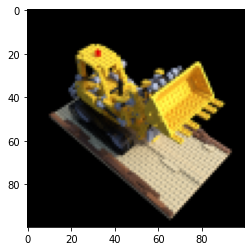

In [45]:
data = np.load('./data/tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

In [46]:
def posenc(x):
    rets = [x]
    for i in range(P_embed):
        for fn in [np.sin, np.cos]:
            rets.append(fn(2.**i * x))
    return np.concatenate(rets, -1)

P_embed = 10
embed_fn = posenc

In [47]:
def viewenc(x):
    rets = [x]
    for i in range(V_embed):
        for fn in [np.sin, np.cos]:
            rets.append(fn(2.**i * x))
    return np.concatenate(rets, -1)

V_embed = 4
embeddirs_fn = viewenc

In [48]:
def get_rays(H, W, focal, c2w):
    """Get ray origins, directions from a pinhole camera."""
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    rays_o = np.broadcast_to(c2w[:3, -1], np.shape(rays_d))
    return rays_o, rays_d

In [49]:
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    if rand: #bug
        random =  np.random.uniform(list(rays_o.shape[:-1]) + [N_samples])
        z_vals += random * ((far-near)/N_samples)
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    print('pts', pts.shape)
    
    pts_flat = np.reshape(pts, [-1, pts.shape[-1]])
    embedded = embed_fn(pts_flat)
    
    #prepare input_data
    viewdirs = rays_d 
    viewdirs = viewdirs / np.linalg.norm(viewdirs, axis=-1, keepdims=True)
    #viewdirs = np.reshape(viewdirs, [-1, 3])
    #print('viewdirs', viewdirs.shape)
        
    input_dirs = np.broadcast_to(viewdirs[:,:, None], pts.shape)
    #print('input_dirs', input_dirs.shape)
    input_dirs_flat = np.reshape(input_dirs, [-1, input_dirs.shape[-1]])
    embedded_dirs = embeddirs_fn(input_dirs_flat)
    input_data = np.concatenate([embedded, embedded_dirs], -1)
    #print('input_data', input_data.shape)
    
    # Run network
    input_layer = network_fn.inputs[0]
    output_layer = network_fn.outputs[0]
    request = network_fn.create_infer_request()
    rets = []
    chunk=1024*64
    for i in range(0, input_data.shape[0], chunk):
        request.infer(inputs={input_layer.any_name: input_data[i:i+chunk]})
        data = request.get_output_tensor(output_layer.index).data
        rets.append(data)
        #print(data.shape)
    raw = np.concatenate(rets, 0)
    raw = np.reshape(raw, list(pts.shape[:-1]) + [4]) # H:W:Samples:4
    #print('raw', raw.shape)

    def ReLU(x):
        return x * (x > 0)
    def Sigmoid(x):
        return  1/(1 + np.exp(-x)) 

    # Compute opacities and colors
    sigma_a =  ReLU(raw[...,3])
    rgb =Sigmoid(raw[...,:3])
    
    print('volume rendering')
    dists = np.concatenate([z_vals[..., 1:] - z_vals[..., :-1], np.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-np.exp(-sigma_a * dists)  
    weights = alpha * np.cumprod(1.-alpha + 1e-10, -1)
    
    rgb_map = np.sum(weights[...,None] * rgb, -2) 
    return rgb_map

pts (100, 100, 64, 3)
volume rendering
5.9626476764678955 secs per iter


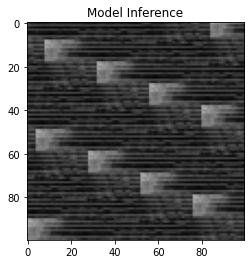

In [50]:
N_samples = 64

import time
t = time.time()
pose = poses[0]
rays_o, rays_d = get_rays(H, W, focal, pose)
rgb = render_rays(compile_model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=False)
print(time.time() - t, 'secs per iter')
plt.imshow(rgb)
plt.title(f'Model Inference')
plt.show()